# Example 6 - Scattered Data and 'Heat Maps'

There are different ways to map point data to a smooth field. One way is to triangulate the data, smooth it and interpolate to a regular mesh (see previous notebooks). It is also possible to construct weighted averages from scattered points to a regular mesh. In this notebook we work through how to find where points lie in the mesh and map their values to nearby vertices. 

## Notebook contents

   - [Computational mesh](#Define-a-regular-computational-mesh)
   - [Scattered data](#Point-data-with-uneven-spatial-distribution)
   - [Data count by triangle](#Count-earthquakes-per-triangle)
   - [Data count by nearest vertex](#Count-earthquakes-per-vertex)
   - [Distance weighting to vertices](#Inverse-distance-weighted-number-of-earthquakes)
   - [Visualisation](#Visualisation)
   
   
The next example is [Ex7-Refinement-of-Triangulations](./Ex7-Refinement-of-Triangulations.ipynb)

## Define a regular computational mesh

Use the (usual) icosahedron with face points included.

In [1]:
import stripy as stripy

mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=5, include_face_points=True, tree=True)

print(mesh.npoints)

30722


## Point data with uneven spatial distribution

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse. As it is a familiar pattern, we use the seismic event catalogue for M5.5+ (dawn of time to 2017-12-31) from IRIS

In [2]:
import numpy as np

# Note - these data have some places where depth is unknown (appears as NaN in the depth )
# The IRIS data has  lat, lon, depth, mag  ... date/time in col 2, 3, 4, 10 (starting from zero)

eqs = np.genfromtxt("../Data/EQ-M5.5-IRIS-ALL.txt", usecols=(2,3,4,10), delimiter='|', comments="#")    
        

lons = np.radians(eqs[:,1])
lats = np.radians(eqs[:,0])
depths = eqs[:,2]
depths[np.isnan(depths)] = -1.0

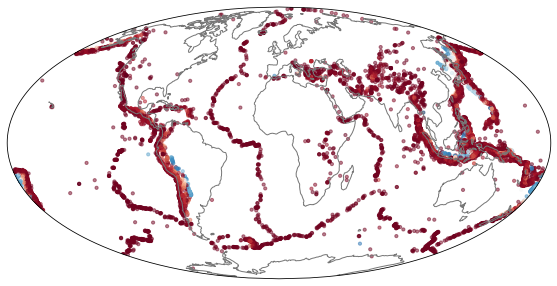

In [3]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="#777777" )
ax.set_global()

lons0 = np.degrees(lons)
lats0 = np.degrees(lats)

ax.scatter(lons0, lats0, 
            marker="o", s=10.0, alpha=0.5, 
            transform=ccrs.PlateCarree(), c=depths, cmap=plt.cm.RdBu)

pass

## Count earthquakes per triangle 

This is a numpy wrapper around the `STRIPACK` routine which operates by retriangulation and is therefore not particularly fast.

In [4]:
triangles = mesh.containing_triangle(lons, lats)

In [ ]:
## The return_counts argument is quite new in numpy and your version may not have it

try:
    tris, counts = np.unique(triangles, return_counts=True)
except:

    def unique_count(a):
        unique, inverse = np.unique(a, return_inverse=True)
        count = np.zeros(len(unique), np.int)
        np.add.at(count, inverse, 1)
        return unique, count

    tris, counts = unique_count(triangles)

In [ ]:
tris.shape

In [ ]:
## map to nodes so we can plot this

hit_count = np.zeros_like(mesh.lons)

for i in range(0, tris.shape[0]):
    hit_count[mesh.simplices[tris[i]]] += counts[i]

hit_count /= 3.0

print(hit_count.mean())

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)

ax.scatter(lons0, lats0, 
            marker="o", s=30.0, transform=ccrs.PlateCarree(), c=hit_count, cmap=plt.cm.Reds, vmin=0.333, vmax=20.0, alpha=0.25)

pass

## Count earthquakes per vertex

The `sTriangulation.nearest_vertices` method uses a k-d tree to find the nearest vertices to a set of longitude / latitude points. It returns the great circle distance. This requires the k-d tree to have been built when the mesh was initialised (`tree=True`)

In [ ]:
distances, vertices = mesh.nearest_vertices(lons, lats, k=1)
nodes, ncounts = np.unique(vertices, return_counts=True)

hit_countn = np.zeros_like(mesh.lons)
hit_countn[nodes] = ncounts

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)

ax.scatter(lons0, lats0, 
            marker="o", s=30.0, transform=ccrs.PlateCarree(), c=hit_countn, cmap=plt.cm.Reds, vmin=0.333, vmax=10.0, alpha=0.25)

pass

## Inverse distance weighted number of earthquakes

The k-d tree method provides a specified number of neighbours and the arc lengths to those neighbours. This can be used in a number of ways to smooth or amalgamate data. Here for example is a weighted average of each earthquake to nearby nodes. 

We compute the distances to $N$ nearby vertices and distribute information to those vertices in inverse proportion to their distance.

$$ w _i = \frac{d _i}{\sum_{i=1}^N d _i} $$

Alternatively, we might map information to the vertices by applying a radially symmetric kernel to the point data without normalising.

In [ ]:
distances, vertices = mesh.nearest_vertices(lons, lats, k=10)
norm = distances.sum(axis=1)

# distances, vertices are arrays of shape (data_size, 10)

hit_countid = np.zeros_like(mesh.lons)

## numpy shouldn't try to vectorise this reduction operation

for i in range(0,distances.shape[0]):
    hit_countid[vertices[i,:]] += distances[i,:] / norm[i]


hit_countidr = np.zeros_like(mesh.lons)

## numpy shouldn't try to vectorise this reduction operation

for i in range(0,distances.shape[0]):
    hit_countidr[vertices[i,:]] += np.exp( -distances[i,:] / 0.02 ) 

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)

ax.scatter(lons0, lats0, 
            marker="o", s=30.0, transform=ccrs.PlateCarree(), c=hit_countid, cmap=plt.cm.Reds, vmin=0.333, vmax=10.0, alpha=0.25)

pass

## Mapping data other than frequency to the regular mesh

Here we show how to map point data to the regular mesh - produce a representation of the depth of the events instead of just their frequency. When plotting, we need to distinguish between zero information and zero (shallow) depth. This is done by using the weight function to determine the opacity of the symbol or field that we plot. This has the effect of washing out the regions with few, large events compared to those with many small ones (which in this case means washed out regions where earthquakes are deep).

In [ ]:
depth_idr = np.zeros_like(mesh.lons)

## numpy shouldn't try to vectorise this reduction operation

for i in range(0,distances.shape[0]):
    depth_idr[vertices[i,:]] += depths[i] * np.exp( -distances[i,:] / 0.02 ) 

depth_idr[hit_countidr != 0.0] /=  hit_countidr[hit_countidr != 0.0]

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)

ax.scatter(lons0, lats0, 
            marker="o", transform=ccrs.PlateCarree(), c=depth_idr, s=hit_countidr,
            cmap=plt.cm.RdBu, vmin=0.0, vmax=500.0, alpha=0.25)

pass

## Visualisation

In [ ]:
import lavavu

from xvfbwrapper import Xvfb
vdisplay = Xvfb()
try:
    vdisplay.start()
    xvfb = True

except:
    xvfb = False


depth_range = depths.max()

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)


tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(mesh.points)
tris.indices(mesh.simplices)

tris.values(hit_count, label="hit_count")
tris.values(hit_countn, label="hit_countn")
tris.values(hit_countid, label="hit_countid")
tris.values(hit_countidr, label="hit_countidr")
tris.colourmap("#FFFFFF:0.0 (1.0)#FF0000:0.2 (50.0)#550044:0.5")


depth = lv.triangles("depth_field",  wireframe=False, colour="#FFFFFF", opacity=0.999)
depth.vertices(mesh.points*(6370-depth_range*0.99) / 6370)
depth.indices(mesh.simplices)
depth.values(depth_idr, label="depths")
depth.values(hit_countidr/hit_countidr.max(), label="weights")
depth.colourmap("#550000 #0099FF #000055")

depth["opacitymap"] = "#000000:0.0 (0.1)#000000:0.9 #000000:0.9"
depth["opacityby"] = "weights"
depth["colourby"]  = "depths"
 
bg = lv.triangles("background",  wireframe=False, colour="#FFFFFF", opacity=1.0)
bg.vertices(mesh.points*(6370-depth_range) / 6370)
bg.indices(mesh.simplices)

ll = np.array(stripy.spherical.lonlat2xyz(lons, lats)).T

nodes = lv.points("events", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(ll * (6370.0 - depths.reshape(-1,1)) / 6370.0 )
nodes.values(depths, label="depths")
nodes.colourmap("#550000 #0099FF #000055")

# View from the pacific hemisphere 
lv.translation(0.0, 0.0, -3.0)
lv.rotation(0.0,90.0, 90.0)


lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.List(property="colourby", options=["hit_count", "hit_countn", "hit_countid", "hit_countidr"], value="hit_count", command="redraw")


lv.control.show()
vdisplay.stop()

The next example is [Ex7-Refinement-of-Triangulations](./Ex7-Refinement-of-Triangulations.ipynb)